In [16]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pytz

In [17]:
metrics = [
    "jvm.total.max", 
    "jvm.total.committed",
    "jvm.non-heap.used",
#     "executor.runTime",   
    "executor.threadpool.activeTasks",
]

memory_metrics = [
    "ExecutorMetrics.ProcessTreeJVMVMemory",
    "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
    "ExecutorMetrics.ProcessTreeOtherRSSMemory",
    "ExecutorMetrics.OnHeapUnifiedMemory",
    "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
    "ExecutorMetrics.OffHeapExecutionMemory",
    "ExecutorMetrics.JVMHeapMemory",
    "ExecutorMetrics.JVMOffHeapMemory",
    "ExecutorMetrics.MappedPoolMemory",
    "ExecutorMetrics.DirectPoolMemory",
    "NettyBlockTransfer.shuffle-server.usedDirectMemory",
    "NettyBlockTransfer.shuffle-server.usedDirectMemory",
    "jvm.heap.init",
    "jvm.heap.used",
    "jvm.heap.max",
    "executor.filesystem.hdfs.write_bytes",
    "executor.filesystem.hdfs.read_bytes", 
    "executor.filesystem.file.write_bytes",
    "executor.filesystem.file.read_bytes", 
]

count_metrics = [
    "executor.memoryBytesSpilled",
    "executor.diskBytesSpilled",
    "executor.shuffleBytesWritten",
    "executor.shuffleLocalBytesRead",
    "executor.shuffleRemoteBytesReadToDisk",
]

metrics = metrics + memory_metrics + count_metrics

In [18]:
data_path = Path("/run/media/berombau/data/thesis/bls-speller-spark/output/metrics")
timezone = 'Europe/Brussels'
dfs = dict()

for file in list(data_path.iterdir()):
    name_parts = file.name.split(".")
    executor = name_parts[1]
    metric = ".".join(name_parts[2:-1])
    if metric not in metrics:
        continue
    df = pd.read_csv(file)
    
    if metric in count_metrics:
        df.rename(columns={'count': 'value'}, inplace=True)
    
    dfs[(executor, metric)] = df

df = pd.concat(dfs)
df

t       value
driver ExecutorMetrics.DirectPoolMemory 0    1605870008           0
                                        1    1605870009           0
                                        2    1605870010           0
                                        3    1605870011           0
                                        4    1605870012           0
...                                                 ...         ...
       jvm.total.max                    104  1605870112  1062207487
                                        105  1605870113  1067450367
                                        106  1605870114  1068498943
                                        107  1605870114  1068498943
                                        108  1605870114  1068498943

[1962 rows x 2 columns]

In [19]:
df_all = df.copy()
df_all = df_all.set_index("t", append=True)
df_all.index = df_all.index.rename(["executor", "metric", "id", "time"])
# df_all = df_all.unstack("metric")
# df_all = df_all.droplevel(0, axis=1)
df_all = df_all.reset_index().drop(columns = "id")
# convert UTC UNIX seconds to datetime
df_all["time"] = pd.to_datetime(df_all['time'], unit='s', utc=True)
# convert UTC to Brussels UTC+1 (timezone of cluster), which Spark UI also uses
df_all["time"] = df_all["time"].dt.tz_convert(timezone)
df_all

,executor,metric,time,value
0,driver,ExecutorMetrics.DirectPoolMemory,2020-11-20 12:00:08+01:00,0
1,driver,ExecutorMetrics.DirectPoolMemory,2020-11-20 12:00:09+01:00,0
2,driver,ExecutorMetrics.DirectPoolMemory,2020-11-20 12:00:10+01:00,0
3,driver,ExecutorMetrics.DirectPoolMemory,2020-11-20 12:00:11+01:00,0
4,driver,ExecutorMetrics.DirectPoolMemory,2020-11-20 12:00:12+01:00,0
...,...,...,...,...
1957,driver,jvm.total.max,2020-11-20 12:01:52+01:00,1062207487
1958,driver,jvm.total.max,2020-11-20 12:01:53+01:00,1067450367
1959,driver,jvm.total.max,2020-11-20 12:01:54+01:00,1068498943
1960,driver,jvm.total.max,2020-11-20 12:01:54+01:00,1068498943


In [20]:
df_nd = df_all

In [21]:
df_all.columns

Index(['executor', 'metric', 'time', 'value'], dtype='object')

# Plot of single executor memory

## Stages

- 0
    - repartition
    - Tools.scala:94
    - 3s
- 1
    - count
    - BlsSpeller.scala:159
    - 0.5s
    - create input motifIterator
- 2
    - repartition
    - Tools.scala:94
    - skipped
- 3
    - flatMap
    - Tools.scala:122
    - 22min
    - run motifIterator
- 4
    - runJob
    - SparkHadoopWriter.scala:78
    - 2.7min
    - write output

## Stage 3

Closer look at stage 3 for exector 1

- 23:46
    - Start of task 1 in stage 3 by exectutor
    - iratic onheap execution memory behaviour
    - growing memory of motifIterator to max 800MB
- 00:01
    - unknown event
    - motifIterator is done?
    - flatMap of 
- 00:05
    - end of task 1
    - all memory metrics to 0
    - exectur is idle

Start of Stage 3 (pipe to MotifIterator). Stage 3 end at 23:05

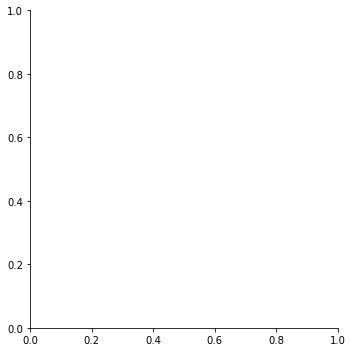

In [22]:

subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "shuffleBytesWritten",
#     "shuffleLocalBytesRead",
#     "shuffleRemoteBytesReadToDisk",
#     "ExecutorMetrics.JVMHeapMemory",
#     "executor.filesystem.hdfs.write_bytes",
# #     "executor.filesystem.hdfs.read_bytes", 
#     "executor.filesystem.file.write_bytes",
#     "executor.filesystem.file.read_bytes", 
    "executor.shuffleBytesWritten",
    "executor.shuffleLocalBytesRead",
    "executor.shuffleRemoteBytesReadToDisk",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
#             .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

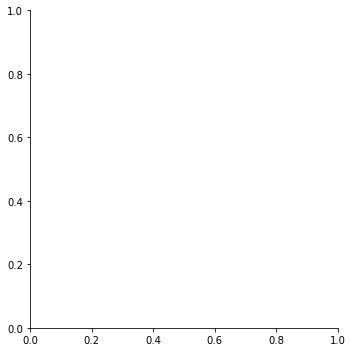

In [23]:

subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "shuffleBytesWritten",
#     "shuffleLocalBytesRead",
#     "shuffleRemoteBytesReadToDisk",
#     "ExecutorMetrics.JVMHeapMemory",
    "executor.filesystem.hdfs.write_bytes",
# #     "executor.filesystem.hdfs.read_bytes", 
    "executor.filesystem.file.write_bytes",
    "executor.filesystem.file.read_bytes", 
    "executor.shuffleBytesWritten",
# #     "executor.shuffleLocalBytesRead",
#     "executor.shuffleRemoteBytesReadToDisk",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
#             .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

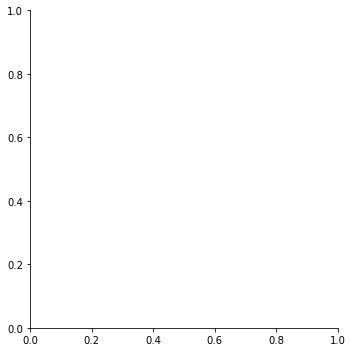

In [24]:

subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
    "jvm.heap.init",
    "jvm.heap.used",
    "jvm.heap.max",
        "ExecutorMetrics.JVMHeapMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
#             .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

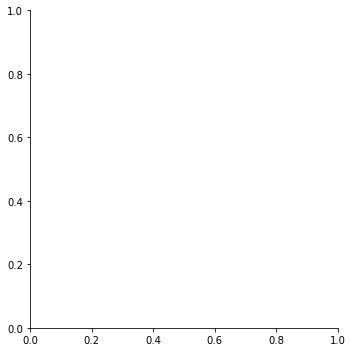

In [25]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
    "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
#             .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

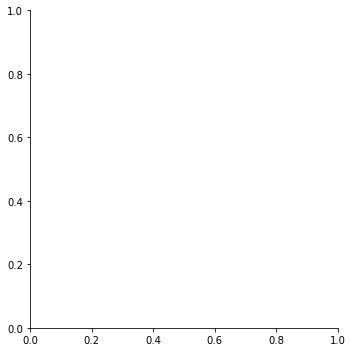

In [26]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
    "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
    "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
#     "executor.memoryBytesSpilled",
#     "executor.diskBytesSpilled",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
#             .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

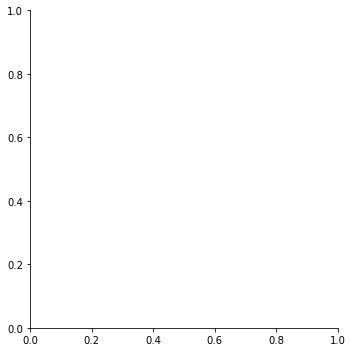

In [27]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
    "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
    "executor.memoryBytesSpilled",
    "executor.diskBytesSpilled",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'"))
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

Same erratic OnHeapExecutionMemory behaviour for all execturs.
Ceiling at 2.6GB

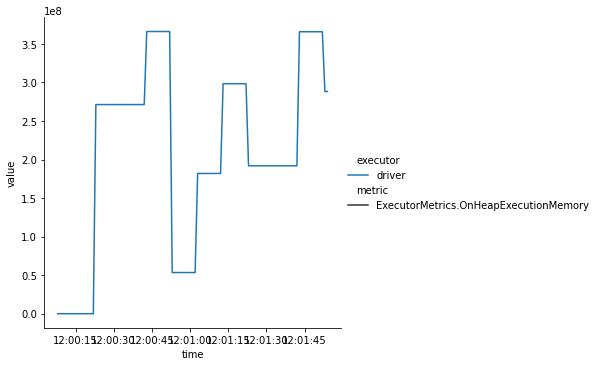

In [28]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="executor", kind="line")

Task 12 at executor 13 has +4 GB of extra memory for motifIterator then the regular 1 GB. Why?
No other metrics are different, except Shuffle Remote Reads of 5.7 MiB instead of <1MiB

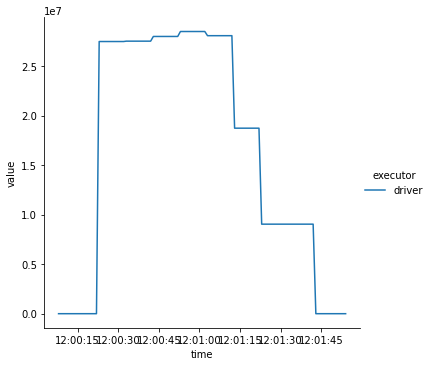

In [29]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemCloserory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="executor", hue="executor", kind="line")

In [30]:
df = pd.DataFrame.from_dict(data)
pd.options.display.max_columns = None
df

NameError: name 'data' is not defined

In [ ]:
df["submissionTime"] = pd.to_datetime(df["submissionTime"], unit="ms")
df["completionTime"] = pd.to_datetime(df["completionTime"], unit="ms")
df["executorCpuTime"] = df["executorCpuTime"] / 1000
df["executorDeserializeCpuTime"] = df["executorDeserializeCpuTime"] / 1000
df

In [ ]:
def plot_n_active_tasks(df):
#     colormap = cm.get_cmap('viridis', df["stageId"].max() + 1)
#     colors = df["jobId"].apply(lambda x: colormap.colors[x])
    plot = df.plot.bar(x="submissionTime", y=["numTasks"])
    
def plot_jvm_cpu_usage(df):
    plot = df.plot.bar(x="submissionTime", y=["executorCpuTime"])

def plot_time_components(df):
    components = [
        "executorDeserializeCpuTime", 
        "executorDeserializeTime",
        "executorCpuTime",
        "shuffleWriteTime",
        "resultSerializationTime",
        "shuffleFetchWaitTime",
        "jvmGCTime",
    ]
#     fig, ax = plt.subplots(1, 1)
    ax = df.plot.line(x="submissionTime", y="executorRunTime", use_index=False)
    df.plot.bar(x="submissionTime", y=components, stacked=True, use_index=False, ax=ax)
    
    
def plot_peak_memory(df):
    plot = df.plot.bar(x="submissionTime", y=["peakExecutionMemory"])

In [ ]:
plot_n_active_tasks(df)
plot_jvm_cpu_usage(df)
plot_time_components(df)
plot_peak_memory(df)